<a href="https://colab.research.google.com/github/nin-ed/Split-Learning/blob/master/Extended_Vanilla_SplitNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial - Extended Vanilla Split Learning

Extended Vanilla Split Learning is basically a combination of multi-layer splitnn and vertically partitioned data. Here all our partitioned input data goes to one location and labels to another location. But instead of just training our model in two locations we can use few trusted locations having more complex model through which we can train our model.

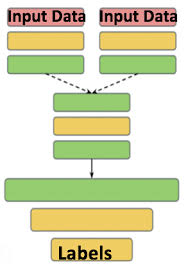



In [0]:
"""import necessary modules"""

import syft, torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [0]:
"""Create hook and virtual workers."""
hook = syft.TorchHook(torch)

"""Bob will hold the first cut layer and the input data."""
bob = syft.VirtualWorker(hook, id='bob')

"""Alice will hold the last cut layer and the labels."""
alice = syft.VirtualWorker(hook, id='alice')

"""Secure Worker will hold the middle cut layer whom we can trust and train the 
   model through it."""
secure_worker = syft.VirtualWorker(hook, id='secure_worker')

### Defining a function create_models which returns a list of models for training.



In [0]:
def create_models(partition, input_size, hidden_sizes, output_size):
    models = list()

    """Create models for each partition in bob's location"""
    for i in range(partition-1):
        models.append(nn.Sequential(nn.Linear(int(input_size/partition), hidden_sizes[0]),
                                    nn.ReLU()))

    """Compute the last remaining features as features may or may not be divided equally."""
    rem = input_size - int(input_size/partition * (partition-1))
    models.append(nn.Sequential(nn.Linear(rem, hidden_sizes[0]),
                                nn.ReLU()))

    """Create a model for secure_worker"""
    """Since all partition models will send information having equal second dimension which is hidden size. So we need
       to multiply input size with partition to match the concatenated layer dimensions."""
    models.append(nn.Sequential(nn.Linear(hidden_sizes[0]*partition, hidden_sizes[1]),
                                nn.ReLU()))

    """Create a model for alice"""
    models.append(nn.Sequential(nn.Linear(hidden_sizes[1], output_size),
                                nn.LogSoftmax(dim=1)))

    return models

### Creating SplitNN class for adding split learning functionality to our model.

In [0]:
class SplitNN:
    def __init__(self, models, optimizers, partition, hidden_sizes):
        super().__init__()
        self.models = models
        self.optimizers = optimizers
        self.partition = partition
        self.hidden = hidden_sizes
        self.outputs = [None] * partition

    def zero_grads(self):
        for opt in self.optimizers:
            opt.zero_grad()

    def forward(self, x):
        for i in range(self.partition):
            self.outputs[i] = self.models[i](x[i])

        """Concatenate outputs of each partitioned model"""
        concat_out = torch.cat(tuple(self.outputs[i] for i in range(self.partition)), dim=1)

        """Transfer this concatenated layer to secure_worker's location"""
        if concat_out.location == self.models[-2].location:
            secure_inp = concat_out.detach().requires_grad_()
        else:
            secure_inp = concat_out.detach().move(self.models[-2].location).requires_grad_()

        """Get the output from secure worker's model"""
        secure_out = self.models[-2](secure_inp)

        """Transfer this output to alice's location"""
        if secure_out.location == self.models[-1].location:
            alice_inp = secure_out.detach().requires_grad_()
        else:
            alice_inp = secure_out.detach().move(self.models[-1].location).requires_grad_()

        """Get the output from alice's model and return it"""
        alice_out = self.models[-1](alice_inp)

        self.concat_out = concat_out
        self.secure_inp = secure_inp
        self.secure_out = secure_out
        self.alice_inp = alice_inp
        self.alice_out = alice_out
        return alice_out

    def backward(self):
        """Get the gradients from alice's location and pass it to secure_worker's location"""
        if self.secure_out.location == self.alice_inp.location:
            grad1 = self.alice_inp.grad.copy()
        else:
            grad1 = self.alice_inp.grad.copy().move(self.secure_out.location)

        """Backpropagate and find the gradients of secure_worker's model"""
        self.secure_out.backward(grad1)

        """Get the gradients from secure_worker's location, and divide and pass it to bob's partitioned models"""
        if self.concat_out.location == self.secure_inp.location:
            grad2 = self.secure_inp.grad.copy()
        else:
            grad2 = self.secure_inp.grad.copy().move(self.models[0].location)

        i = 0
        while i < self.partition - 1:
            self.outputs[i].backward(grad2[:, self.hidden[0] * i: self.hidden[0] * (i + 1)], retain_graph=True)
            i += 1
        self.outputs[i].backward(grad2[:, self.hidden[0] * i:], retain_graph=True)


    def step(self):
        for opt in self.optimizers:
            opt.step()

### Defining a function to train our model

In [0]:
def training(models, splitNN, data, target, epochs):
    def train(data, target, splitnn):
        splitnn.zero_grads()
        pred = splitnn.forward(data)
        criterion = nn.NLLLoss()
        loss = criterion(pred, target)
        loss.backward()
        splitnn.backward()
        splitnn.step()
        return loss

    avg_loss = 0.
    for e in range(epochs):
        total_loss = 0.
        data1, data2, data3 = data
        for x1, x2, x3, y in zip(data1, data2, data3, target):
            x1, x2, x3 = x1.send(models[0].location), x2.send(models[0].location), x3.send(models[0].location)
            y = y.send(models[-1].location)
            loss = train([x1, x2, x3], y, splitNN)
            total_loss += loss.get()

        avg_loss += total_loss/len(data[0])
        print(f"Epoch: {e+1}... Training Loss: {total_loss/len(data[0])}")

    print(f"Average Loss: {avg_loss/epochs}")

Now lets define a main function.

In [0]:
def main():
    """Assign the number of partitions in vertically partitioned data."""
    partition = 3

    """Define a transform"""
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])

    """Import dataset and load it."""
    trainset = datasets.MNIST('mnist', download=False, train=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

    """Lets define sizes."""
    input_size = 784
    hidden_sizes = [128, 256, 512]
    output_size = 10

    """Lets create 3 lists that would act as our vertically paritioned datasets and one list for labels"""
    image_set1, image_set2, image_set3 = list(), list(), list()
    labels = list()

    """Assign how many data should contain in a single dataset. Since mnist dataset have a shape of [28 x 28 x 1] and we
       sliced the dataset in 64 batches, after reshaping it would be [64 x 784]. Now we have to divide these 784 
       features into three datasets"""
    distr = int(input_size/partition)

    for image, label in trainloader:
        image = image.view(image.shape[0], -1)
        image_set1.append(image[:, 0:distr])
        image_set2.append(image[:, distr:distr*2])
        image_set3.append(image[:, distr*2:])
        labels.append(label)

    models = create_models(partition, input_size, hidden_sizes, output_size)

    optimizers = [optim.SGD(model.parameters(), lr=0.01) for model in models]

    """Build a list locations where each model has to be sent."""
    model_locations = list()
    for _ in range(partition):
        model_locations.append(bob)
    model_locations.append(secure_worker)
    for _ in range(partition):
        model_locations.append(alice)

    """Send each model to its specific location."""
    for model, location in zip(models, model_locations):
        model.send(location)

    """Create an object of SplitNN class"""
    splitNN = SplitNN(models, optimizers, partition, hidden_sizes)

    """Now to train our model, call training function."""
    epochs = 20
    training(models, splitNN, [image_set1, image_set2, image_set3], labels, epochs)

In [0]:
if __name__ == '__main__':
    main()